In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set_style("darkgrid")
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
data = pd.read_csv('Datasets/1996 to 2023 CombinedData.csv')

In [4]:
df = data.reset_index()[:2000]

In [5]:
df.head()

,index,Unnamed: 0,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,0,0,"14.65, 121.05",1996-01-01,26.1,20.9,23.4,26.1,20.9,23.4,...,NaN,NaN,NaN,1996-01-01T06:20:44,1996-01-01T17:37:09,0.34,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"98432099999,98429099999,98428041224,9843409999..."
1,1,1,"14.65, 121.05",1996-01-02,28.1,20.7,24.3,29.7,20.7,24.8,...,NaN,NaN,NaN,1996-01-02T06:21:07,1996-01-02T17:37:43,0.37,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"98432099999,98429099999,98428041224,9843409999..."
2,2,2,"14.65, 121.05",1996-01-03,27.1,19.1,23.5,28.6,19.1,23.6,...,NaN,NaN,NaN,1996-01-03T06:21:28,1996-01-03T17:38:18,0.41,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"98432099999,98429099999,98430099999,69176499999"
3,3,3,"14.65, 121.05",1996-01-04,28.1,0.1,23.0,29.3,-5.5,23.0,...,NaN,NaN,NaN,1996-01-04T06:21:49,1996-01-04T17:38:53,0.44,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"98432099999,98429099999,98434099999,69176499999"
4,4,4,"14.65, 121.05",1996-01-05,26.6,19.1,23.0,26.6,19.1,23.0,...,NaN,NaN,NaN,1996-01-05T06:22:09,1996-01-05T17:39:27,0.48,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,"98432099999,98429099999,98428041224,9843409999..."


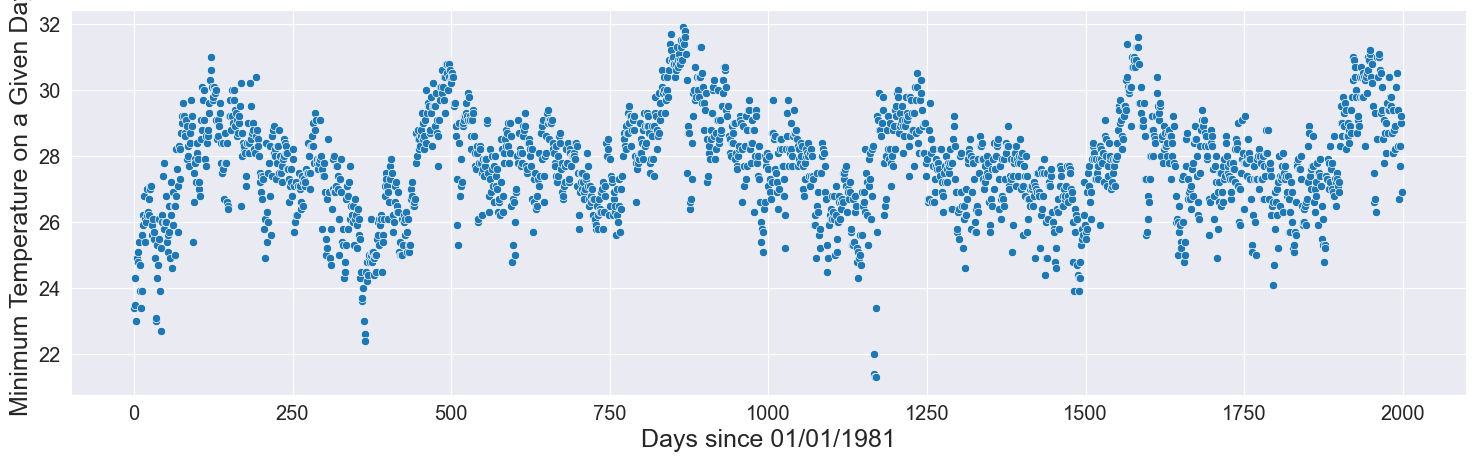

In [6]:
plt.figure(figsize=(18, 5))
sns.scatterplot(data=df, x='index', y='temp')
plt.xlabel('Days since 01/01/1981', fontsize=18)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=18)
#plt.savefig('filename.png', dpi=300)
plt.show()


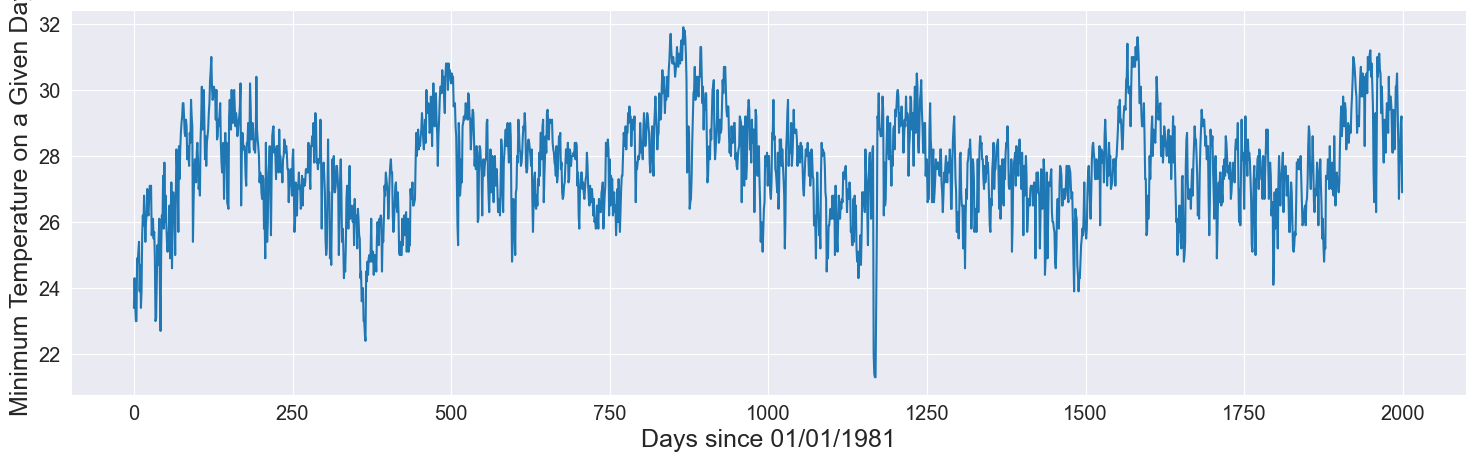

In [7]:
plt.figure(figsize=(18, 5))
plt.plot(df["temp"])
plt.xlabel('Days since 01/01/1981', fontsize=18)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=18)
#plt.savefig('filename.png', dpi=300)
plt.show()


## Processing Data
#### The graph shows obvious seasonality, so a good hypothesis would be that the mean temperature has a huge dependance on the month.
#### Additionally, a good practice is to keep the mean of the data at 0.
####Ultimately our goal is to make the dataset as close as possible to being stationary, so we can easily model it.

In [8]:
df['TempMod'] = df['temp']

In [9]:
df['Month'] = pd.DatetimeIndex(df['datetime']).month

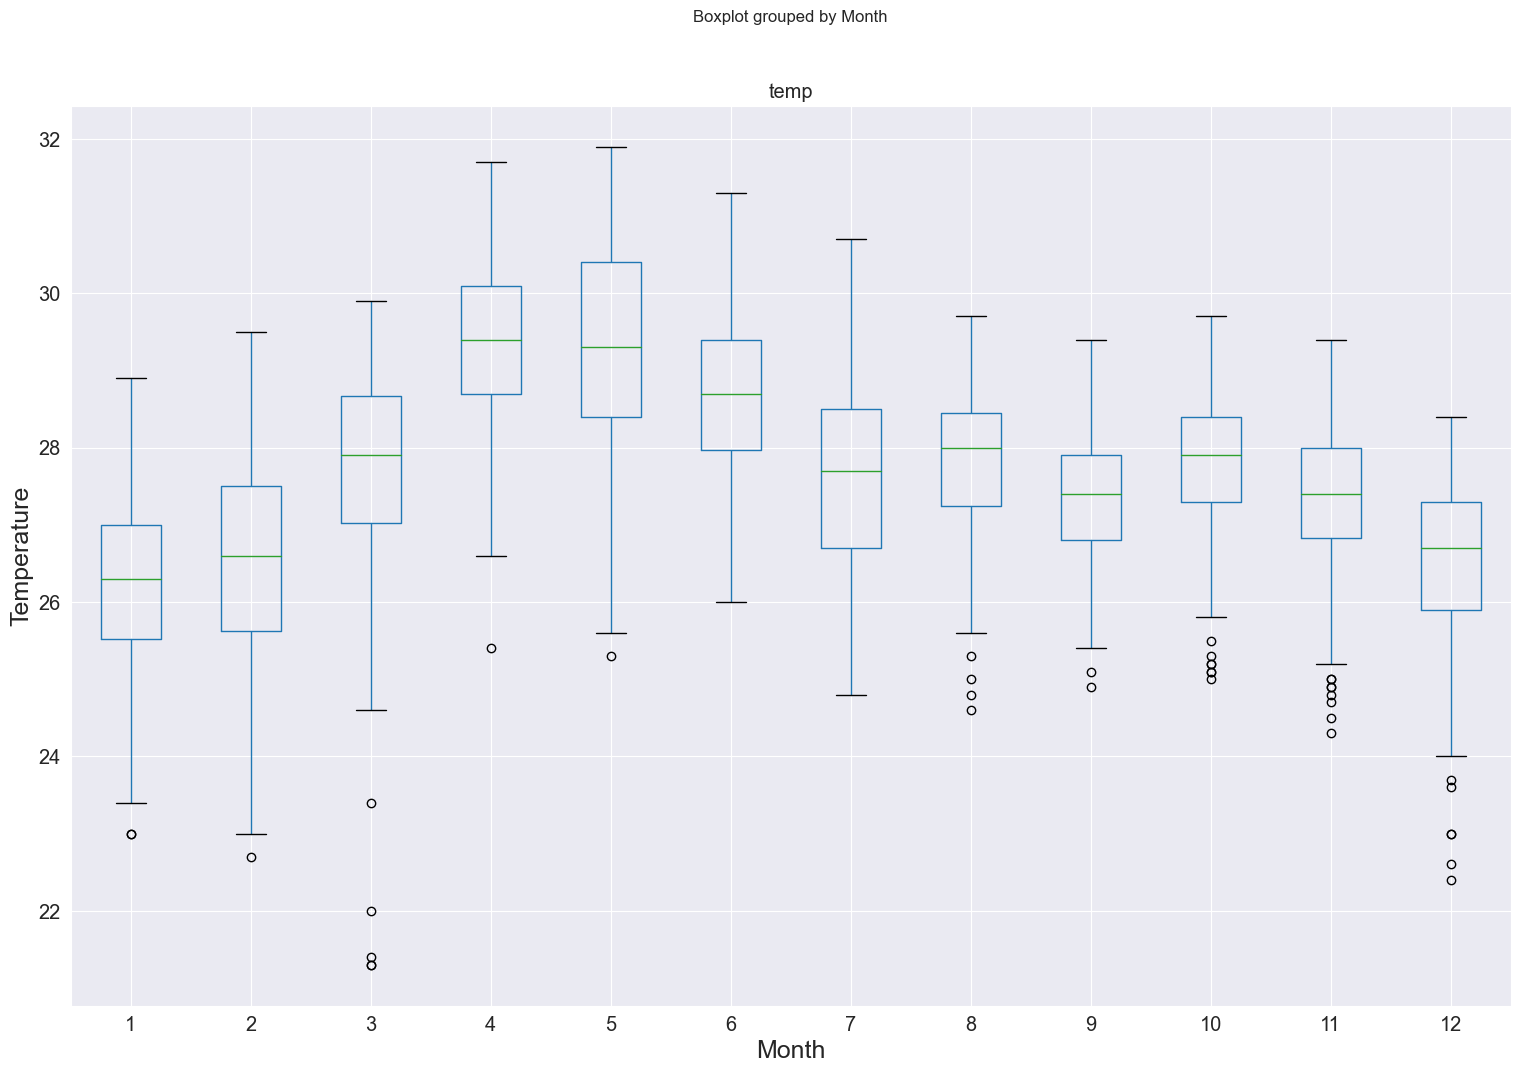

In [10]:
fig, ax = plt.subplots(figsize=(18,12))
plt.suptitle('')
df.boxplot(column=['temp'], by='Month', ax=ax)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.show()

Here it's obvious that there is a very good connection between month and temperature, and that the connection explains the seasonality of this data. Thus we will proceed to remove this seasonality.

In [11]:
# Need to Do all of this to remove the seasonality of data (and make it a linear Regression)

# Get The Mean for each Month for Temp
month_grp = df.groupby(by='Month').mean(numeric_only = True)['temp']

# For Every Month in the list of unique Months in the Dataframe
for month in df['Month'].unique():
  # Look for df["Month"] == current unique month, Change TempMod Value to be (currentTemp of the Day) - (Monthly Mean)
  df.loc[df['Month'] == month, 'TempMod'] -= month_grp[month]
  
# Get The Mean of the Normalized Month Groups
mean = df['TempMod'].mean()
print("Current Mean:", mean)

# Subtract the Normalized Temperature Mean by the Total Mean of all the other Normalized
df['TempMod'] = df['TempMod'] - mean

Current Mean: 3.552713678800501e-17


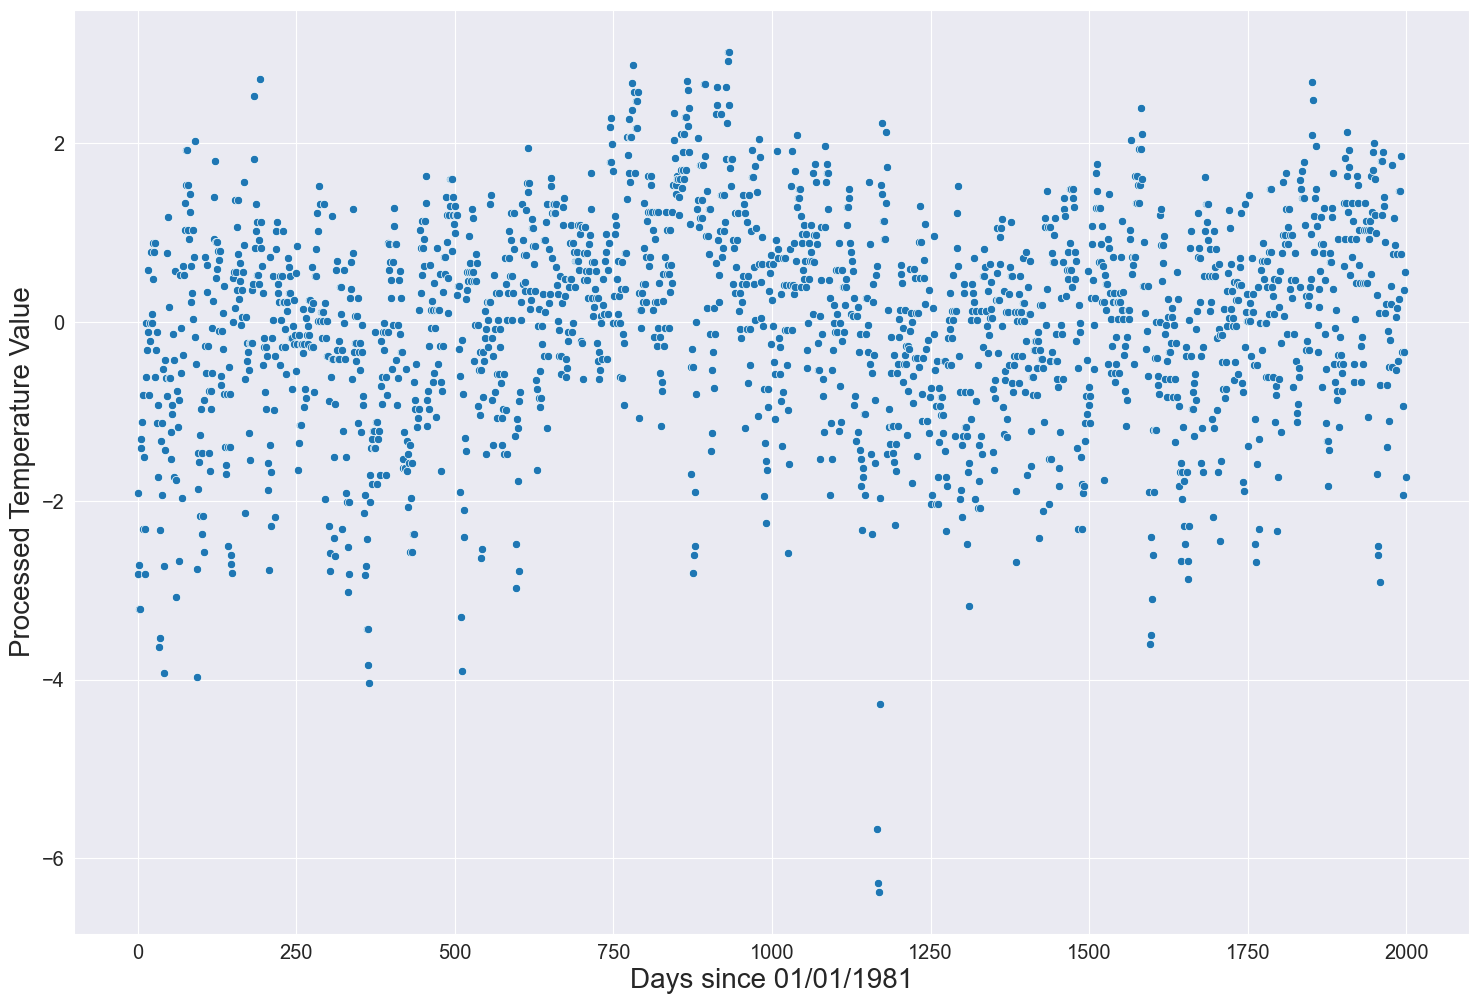

In [12]:
# This should now display a pretty non seasonal data, ultimately converting Non Linear to Linear
plt.figure(figsize=(18, 12))
sns.scatterplot(data=df, x='index', y='TempMod')
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Processed Temperature Value', fontsize=20)
plt.show()

In [13]:
df['TempMod'].mean()

3.552713678800501e-17

An important step is to understand the order of the model we want, be it an AR, MA, ARMA or ARIMA model. We can best infer the order from the graphs of Autocorrelation and Partial Autocorrelation of the data.

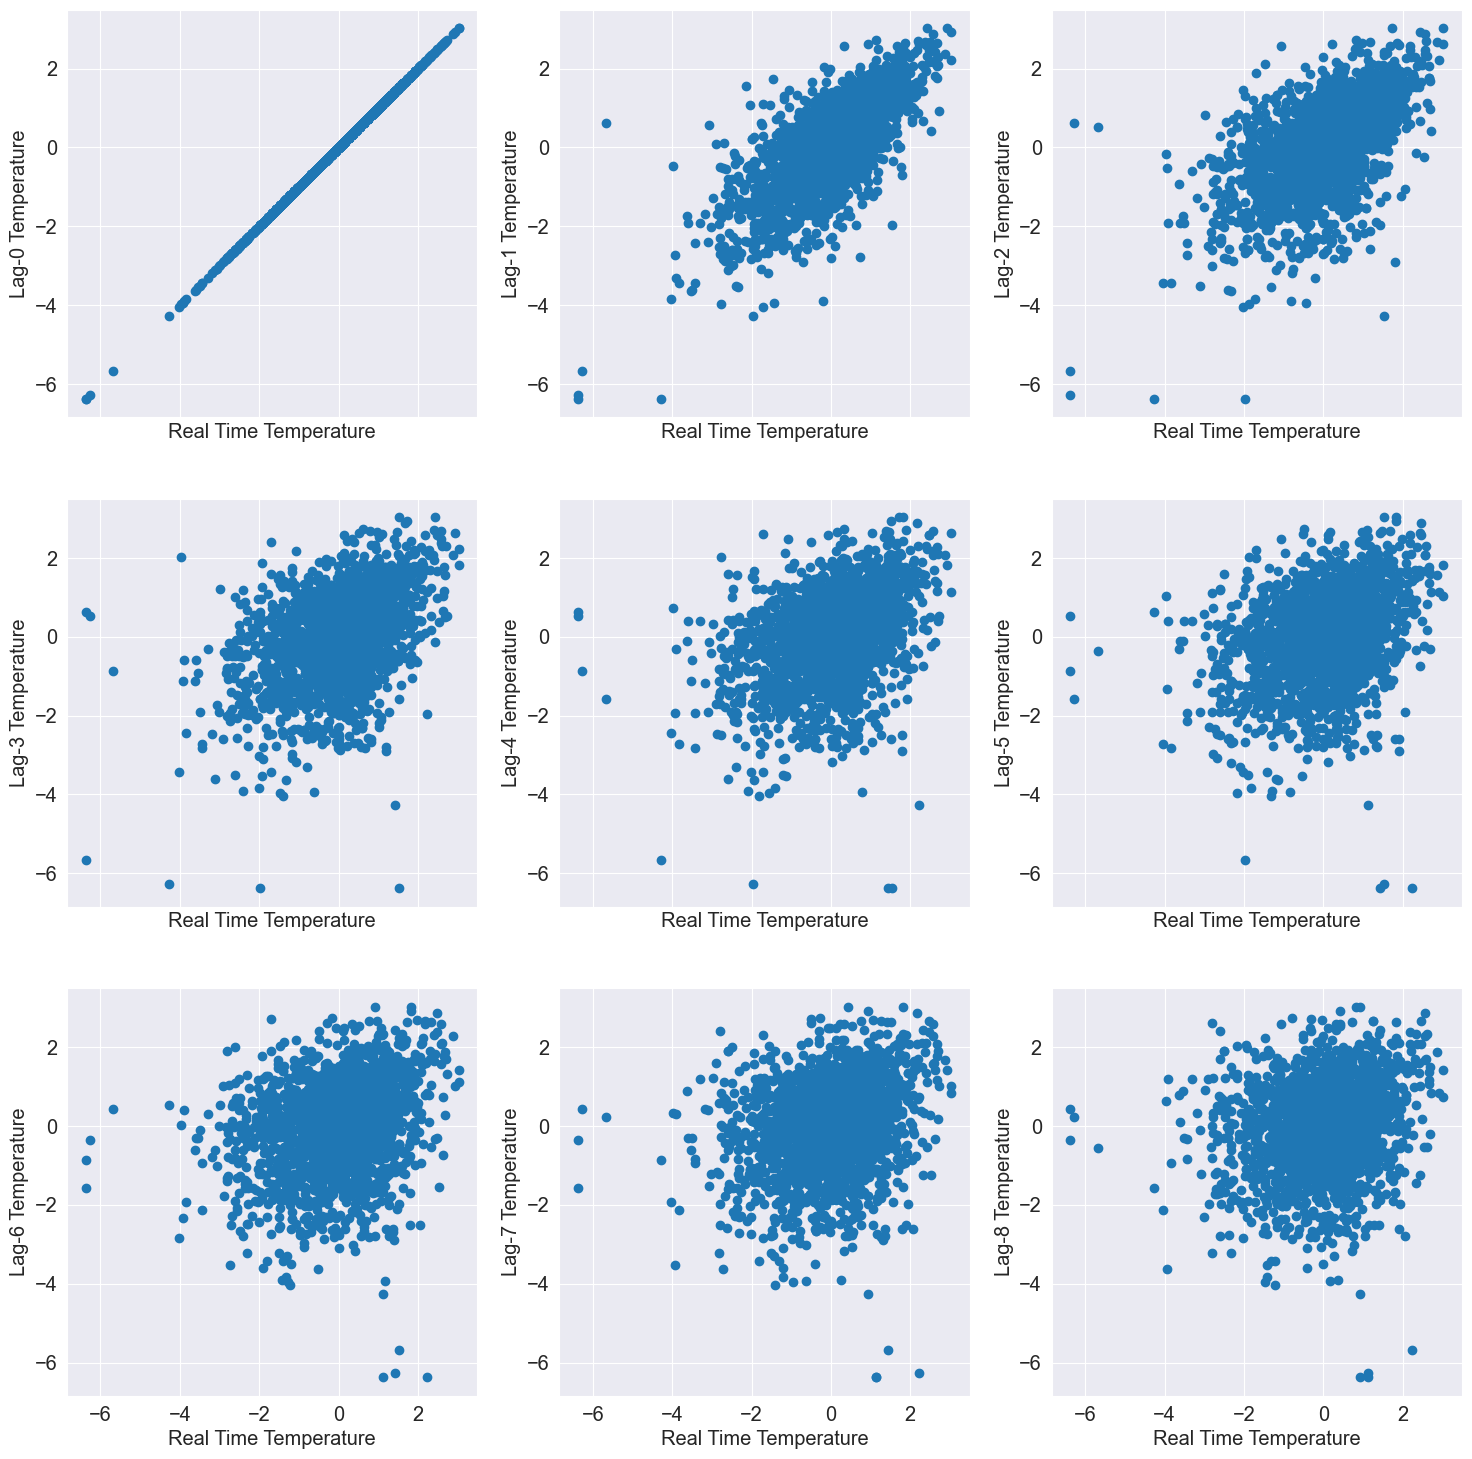

In [14]:
n = 9
current = df['TempMod'][n:]
fig, axis = plt.subplots(3, n//3, sharex=True, figsize=(18, 18))

for i in range(n):
  if i != 0:
    lag = df['TempMod'][(n-i):-i]
  else:
    lag = current
  axis[(i)//3, (i)%3].set(xlabel='Real Time Temperature', ylabel=f'Lag-{i} Temperature')
  axis[(i)//3, (i)%3].scatter(current, lag)

plt.show()

In [15]:
auto_corr = [df['TempMod'].autocorr(lag=k) for k in range(1, 50)]

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

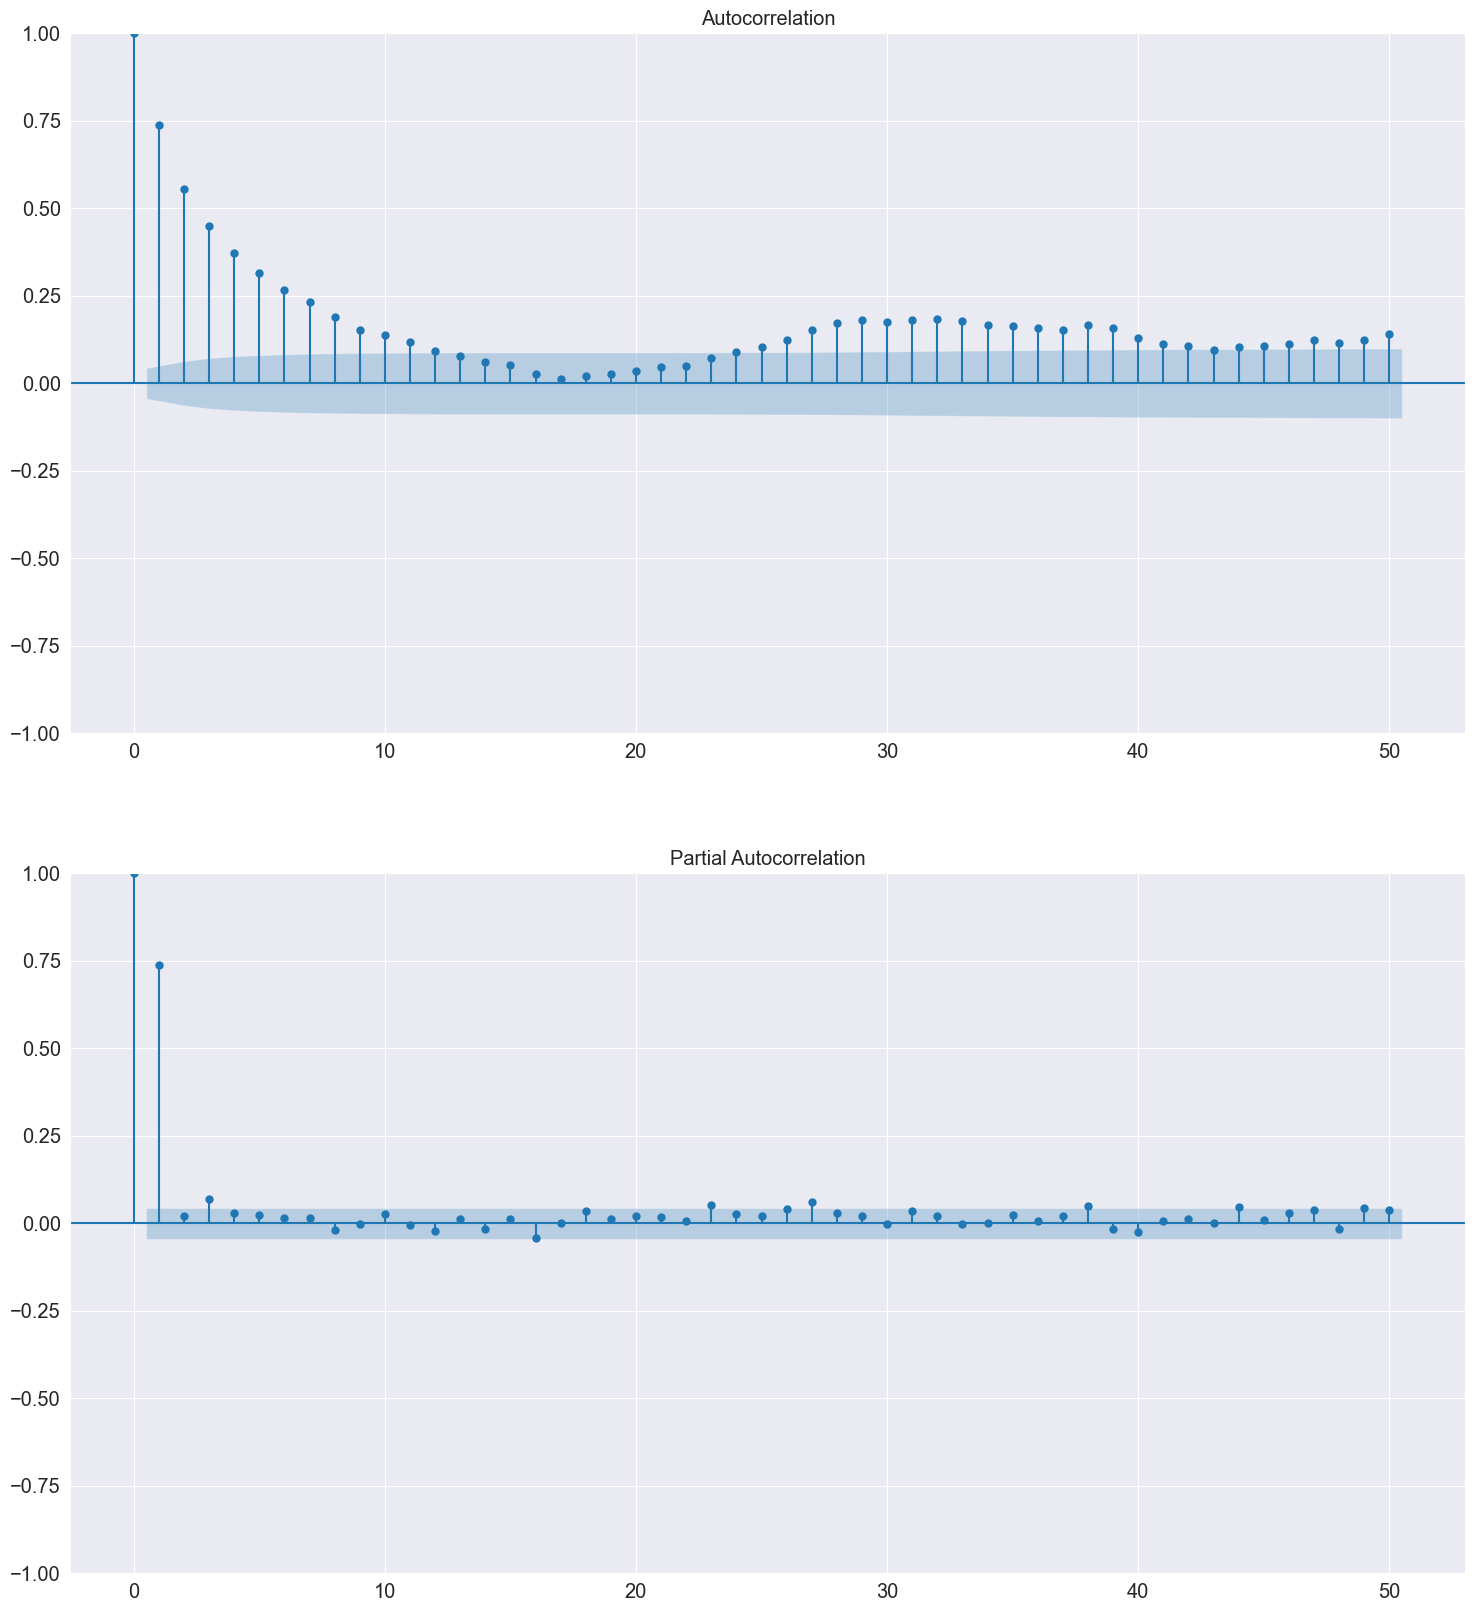

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(18, 20), sharey=True)

plot_acf(ax=axes[0], x=df['TempMod'], lags=50)

plot_pacf(ax=axes[1], x=df['TempMod'], lags=50)

plt.show()

In [18]:
X = df['TempMod']
X.head()
print(len(X))

2000


# AR(p)
$
X_t = \sum_{i=1}^p -\psi_i X_{t-i}+\eta_t
$

$\eta_i = N(0, \sigma_\eta^2)$

In [19]:
class AR:
  def __init__(self, p):
    self.p = p
    self.model = LinearRegression()
    self.sigma = None

  def generate_train_x(self, X):
    n = len(X)
    ans = X[:n-self.p]
    ans = np.reshape(ans, (-1, 1))
    for k in range(1, self.p):
      temp = X[k:n-self.p+k]
      temp = np.reshape(temp, (-1, 1))
      ans = np.hstack((ans, temp))
    return ans
  
  def generate_train_y(self, X):
    return X[self.p:]

  def fit(self, X):
    self.sigma = np.std(X)
    train_x = self.generate_train_x(X)
    train_y = self.generate_train_y(X)
    self.model.fit(train_x, train_y)

  def predict(self, X, num_predictions, mc_depth):
    X = np.array(X)
    ans = np.array([])

    for j in range(mc_depth):
      ans_temp = []
      a = X[-self.p:]

      for i in range(num_predictions):
        next = self.model.predict(np.reshape(a, (1, -1))) + np.random.normal(loc=0, scale=self.sigma)

        ans_temp.append(next)
        
        a = np.roll(a, -1)
        a[-1] = next
      
      if j==0:
        ans = np.array(ans_temp)
      
      else:
        ans += np.array(ans_temp)
    
    ans /= mc_depth

    return ans
  
  def score(self, X):
    train_x = self.generate_train_x(X)
    train_y = self.generate_train_y(X)
    return self.model.score(train_x, train_y)

In [20]:
p=3
n_train = 2000
n=3600
model = AR(p)

In [21]:
X = np.array(X)
print(len(X))
model.fit(X)

2000


In [22]:
prediction = model.predict(X[:p], n, 1)
prediction = np.reshape(prediction, (-1,))
prediction = np.hstack((X[:p], prediction))
prediction.shape

(3603,)

In [23]:
real = df[:2000]['TempMod']
len(real)

2000

In [40]:
prediction.shape

(3603,)

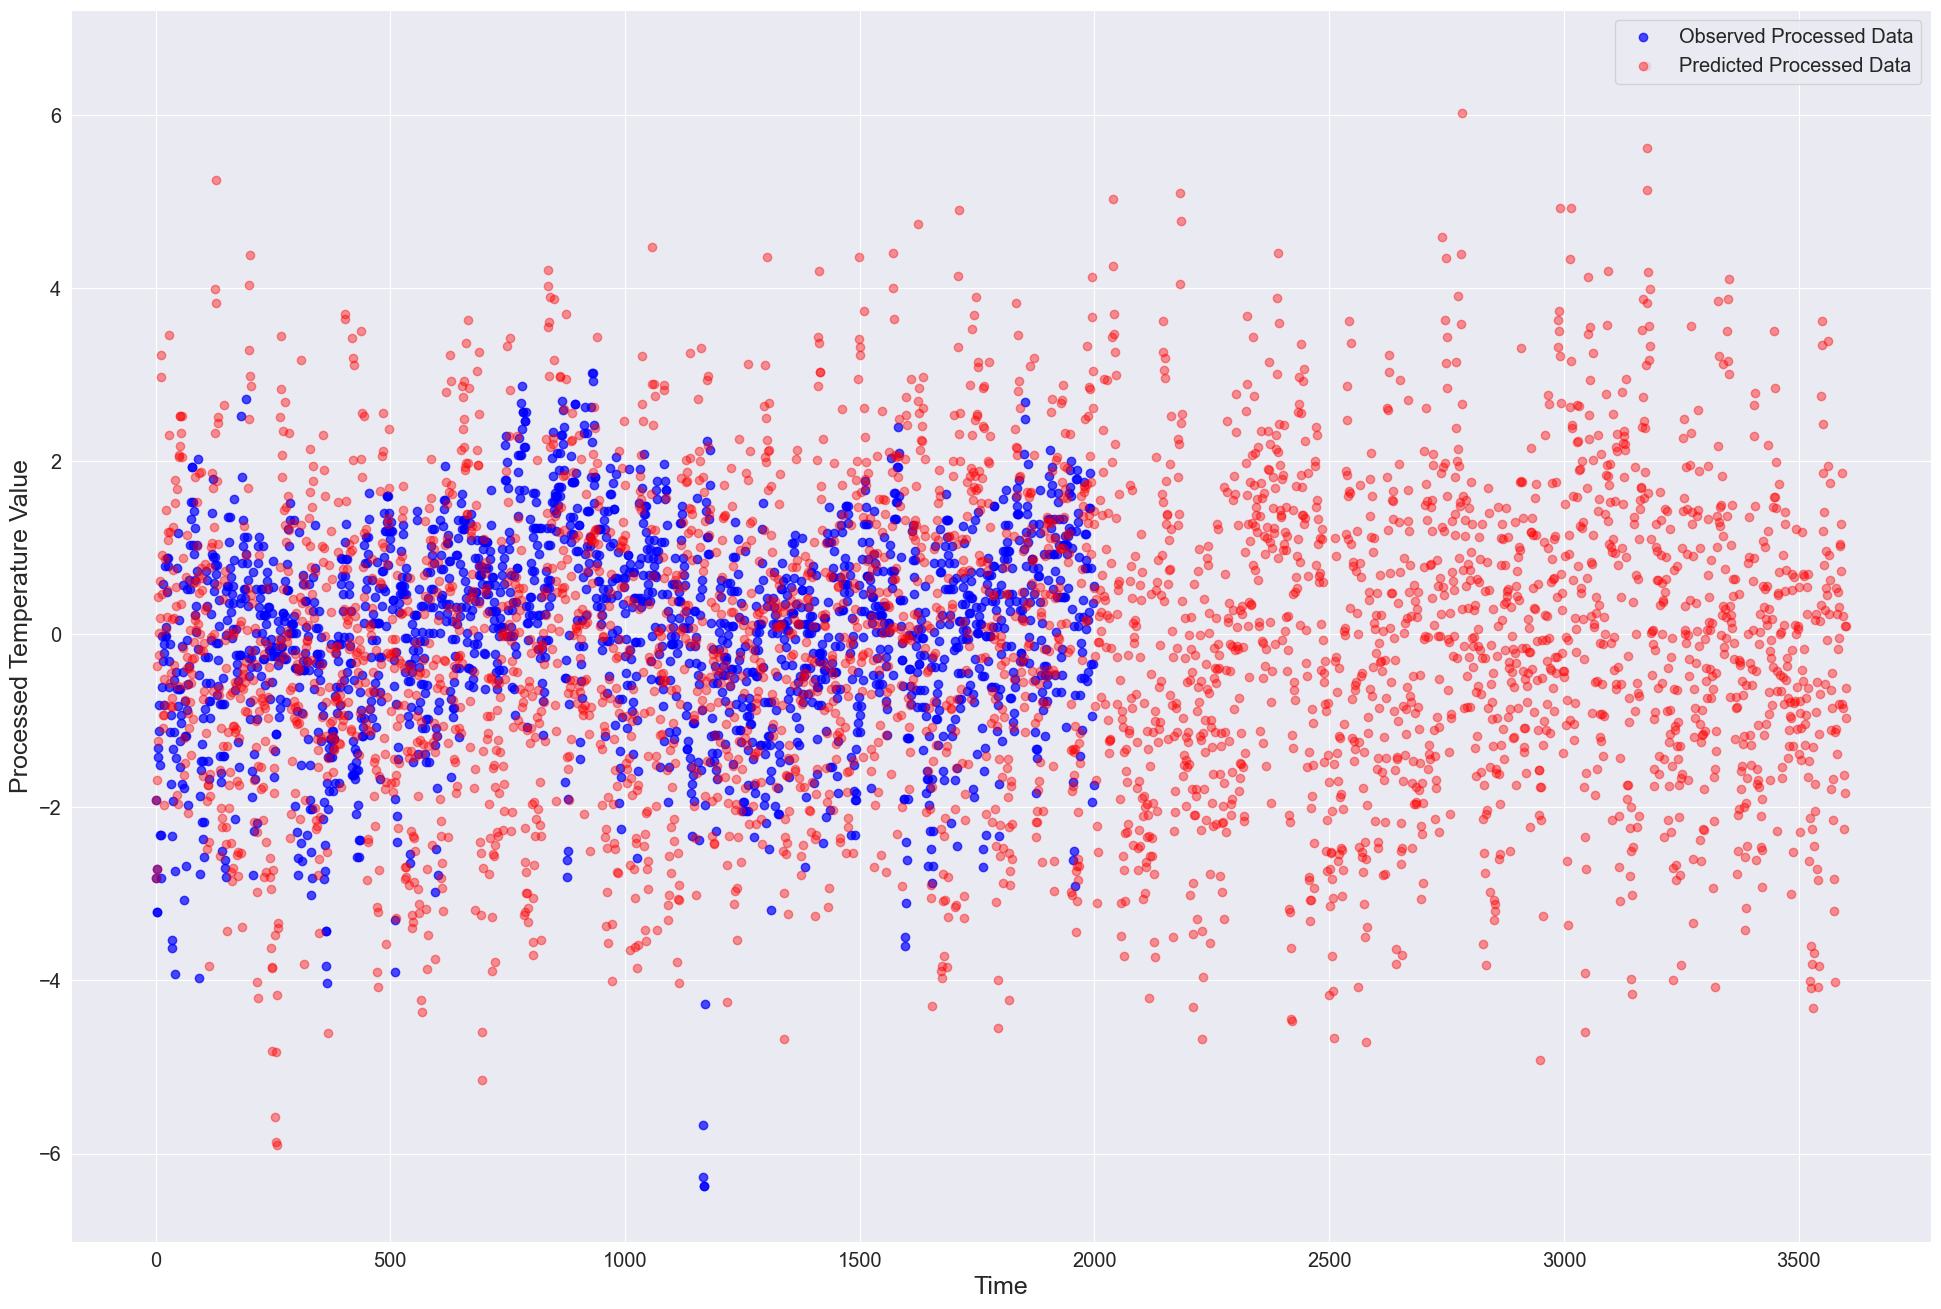

In [42]:
# Performing a sanity check on the data
plt.figure(figsize=(24, 16))
plt.scatter(x=np.arange(2000), y=real, color='blue', alpha=0.7)
plt.scatter(x=np.arange(2000), y=prediction[:2000], color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

In [25]:
model.score(X)

0.5499706128356882

In [26]:
pred_dates = data['datetime'][:len(prediction)]
prediction

array([-2.81451613, -1.91451613, -2.71451613, ..., -0.61946152,
       -0.96718173,  0.09858827])

In [27]:
preds = pd.concat(objs=[pred_dates, pd.Series(prediction)], axis=1)

In [28]:
preds.columns = ['Date', 'PredTemp']
preds['Month'] = pd.DatetimeIndex(preds['Date']).month
preds

,Date,PredTemp,Month
0,1996-01-01,-2.814516,1
1,1996-01-02,-1.914516,1
2,1996-01-03,-2.714516,1
3,1996-01-04,-1.686061,1
4,1996-01-05,-0.365574,1
...,...,...,...
3598,2005-11-07,-1.828950,11
3599,2005-11-08,0.092163,11
3600,2005-11-09,-0.619462,11
3601,2005-11-10,-0.967182,11


In [29]:
preds['Zero'] = 0
preds

,Date,PredTemp,Month,Zero
0,1996-01-01,-2.814516,1,0
1,1996-01-02,-1.914516,1,0
2,1996-01-03,-2.714516,1,0
3,1996-01-04,-1.686061,1,0
4,1996-01-05,-0.365574,1,0
...,...,...,...,...
3598,2005-11-07,-1.828950,11,0
3599,2005-11-08,0.092163,11,0
3600,2005-11-09,-0.619462,11,0
3601,2005-11-10,-0.967182,11,0


In [30]:
preds = preds.reset_index()

In [31]:
month_grp = (df.groupby(by='Month').mean(numeric_only = True)['temp'])
for month in df['Month'].unique():
  preds.loc[preds['Month']==month, 'PredTemp'] += month_grp[month]
  preds.loc[preds['Month']==month, 'Zero'] += month_grp[month]

In [32]:
for month in df['Month'].unique():
  preds.loc[preds['Month']==month, 'Zero'] += month_grp[month]

In [33]:
preds['PredTemp'] += mean
preds.tail()

,index,Date,PredTemp,Month,Zero
3598,3598,2005-11-07,25.485717,11,54.629333
3599,3599,2005-11-08,27.406830,11,54.629333
3600,3600,2005-11-09,26.695205,11,54.629333
3601,3601,2005-11-10,26.347485,11,54.629333
3602,3602,2005-11-11,27.413255,11,54.629333


In [34]:
preds['Zero'] += mean
preds.tail()

,index,Date,PredTemp,Month,Zero
3598,3598,2005-11-07,25.485717,11,54.629333
3599,3599,2005-11-08,27.406830,11,54.629333
3600,3600,2005-11-09,26.695205,11,54.629333
3601,3601,2005-11-10,26.347485,11,54.629333
3602,3602,2005-11-11,27.413255,11,54.629333


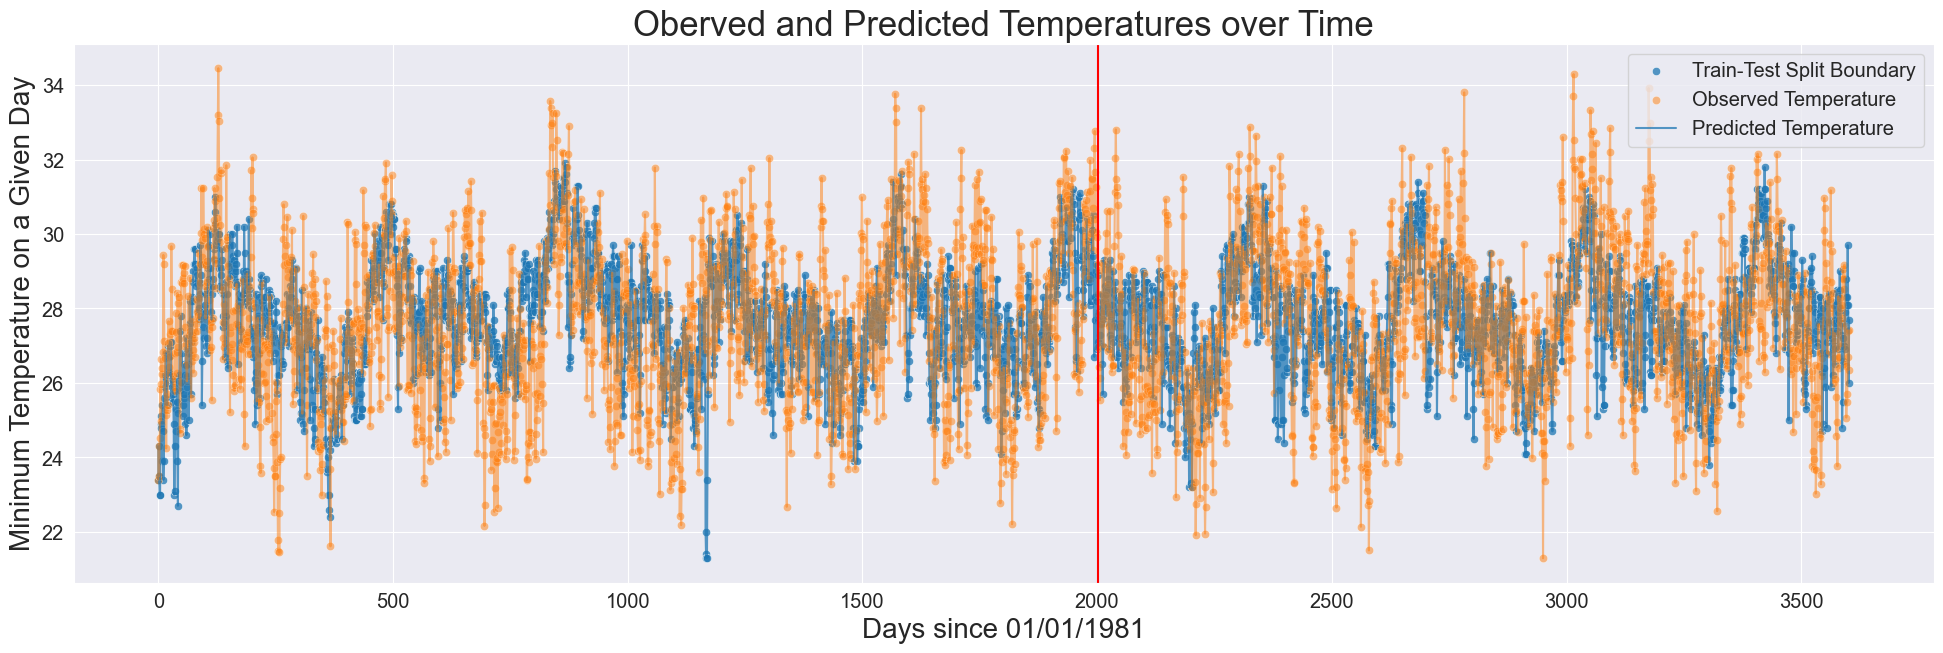

In [43]:
plt.figure(figsize=(24, 7))
plt.title('Oberved and Predicted Temperatures over Time', fontsize=25)
sns.scatterplot(x=preds['index'], y=data['temp'], alpha=0.75)
sns.scatterplot(x=preds['index'], y=preds['PredTemp'], alpha=0.5)
sns.lineplot(x=preds['index'], y=data['temp'], alpha=0.75)
sns.lineplot(x=preds['index'], y=preds['PredTemp'], alpha=0.5)
plt.axvline(x=n_train+p, c='red')
plt.legend(loc='upper right', labels=['Train-Test Split Boundary','Observed Temperature', 'Predicted Temperature'])
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=20)
plt.show()

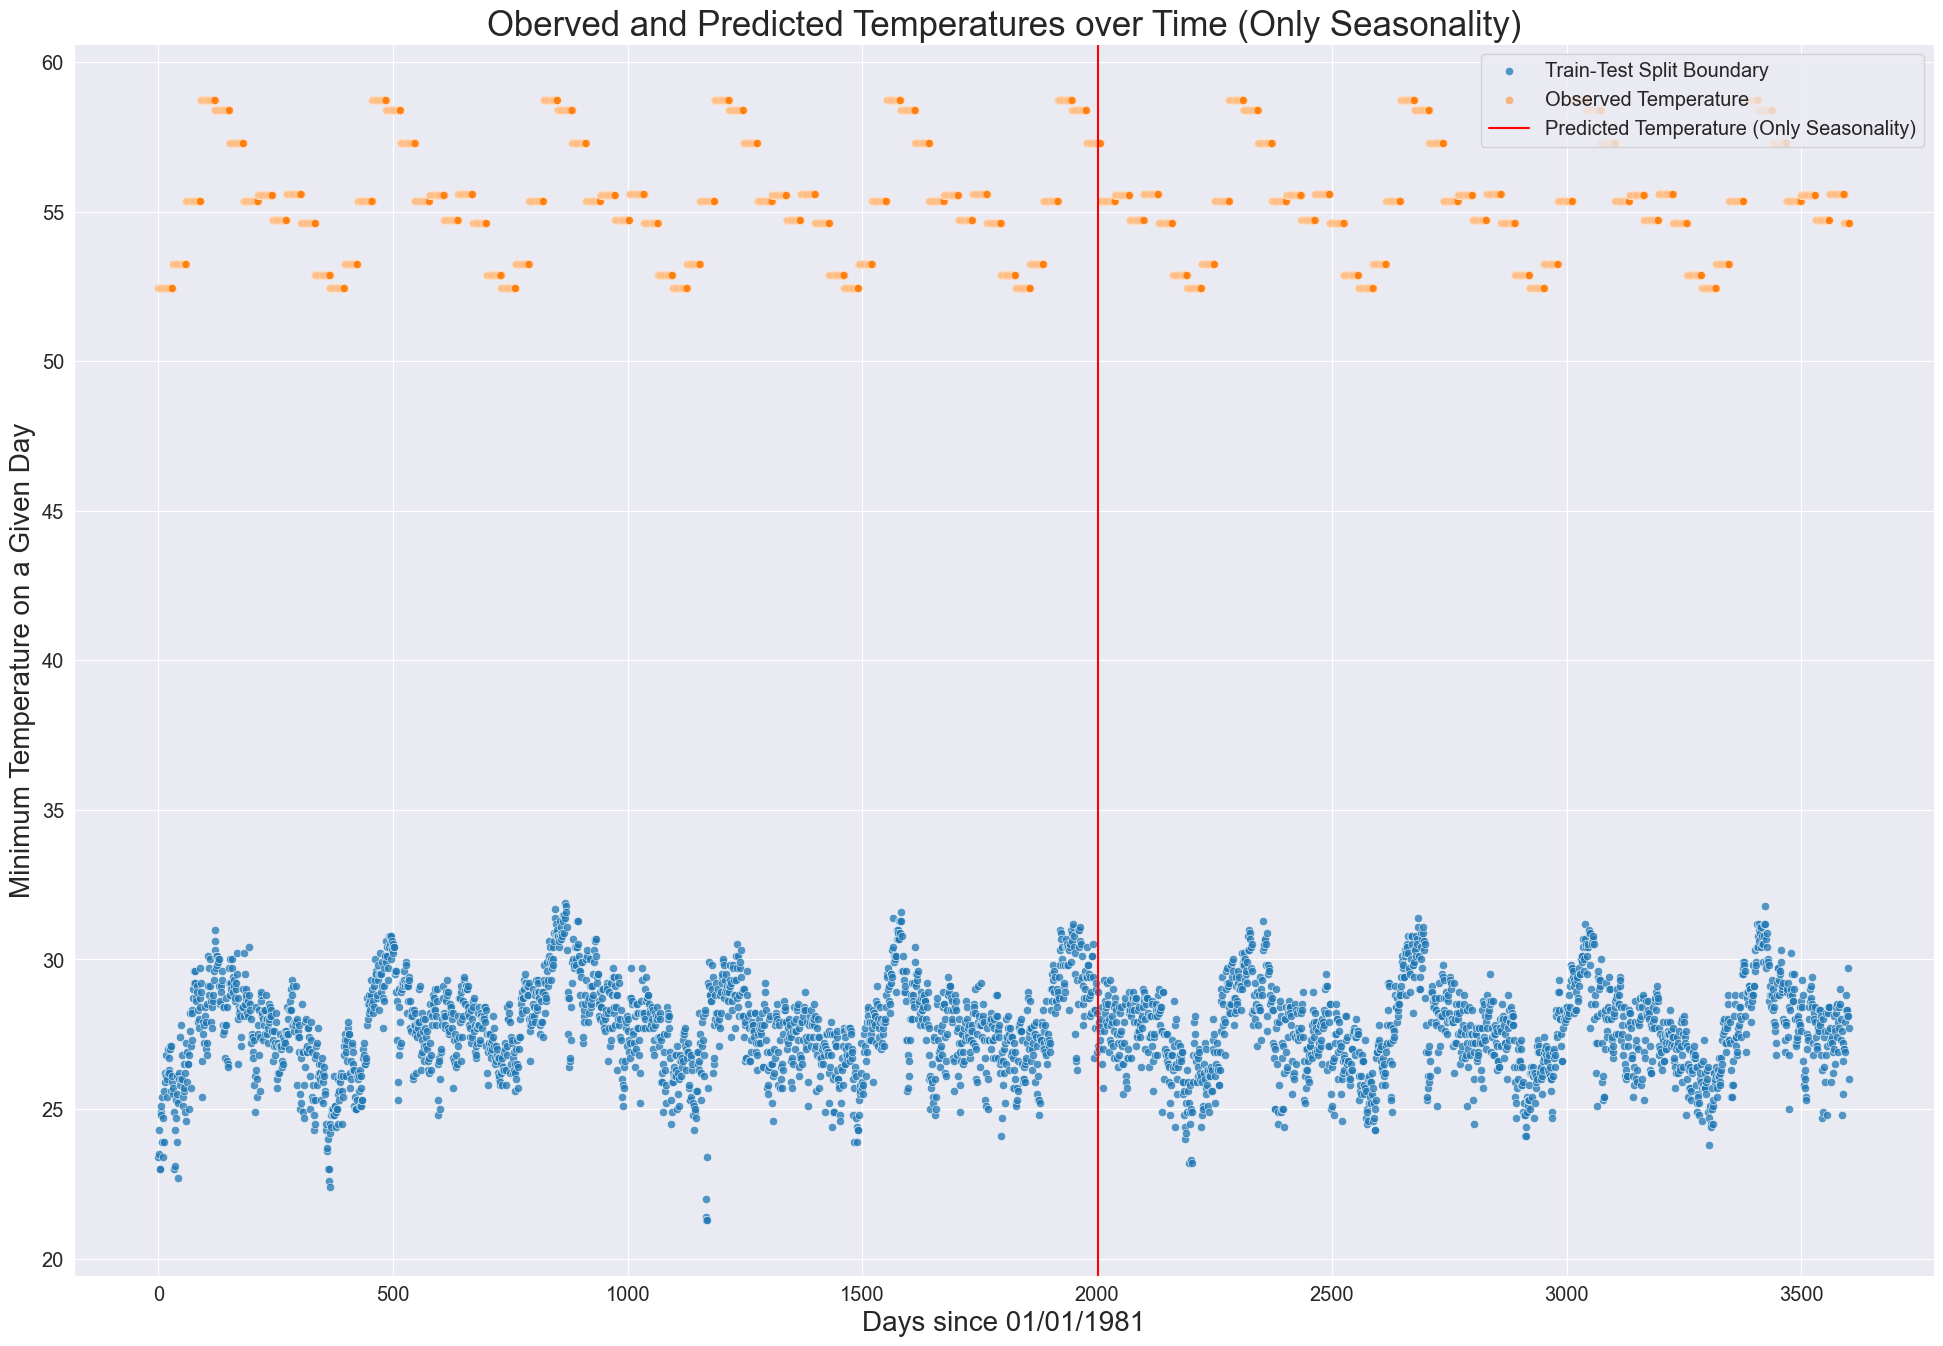

In [37]:
plt.figure(figsize=(24, 16))
plt.title('Oberved and Predicted Temperatures over Time (Only Seasonality)', fontsize=25)
sns.scatterplot(x=preds['index'], y=data['temp'], alpha=0.75)
sns.scatterplot(x=preds['index'], y=preds['Zero'], alpha=0.5)
plt.axvline(x=n_train+p, c='red')
plt.legend(loc='upper right', labels=['Train-Test Split Boundary','Observed Temperature', 'Predicted Temperature (Only Seasonality)'])
plt.xlabel('Days since 01/01/1981', fontsize=20)
plt.ylabel('Minimum Temperature on a Given Day', fontsize=20)
plt.show()

## Graphs for Medium

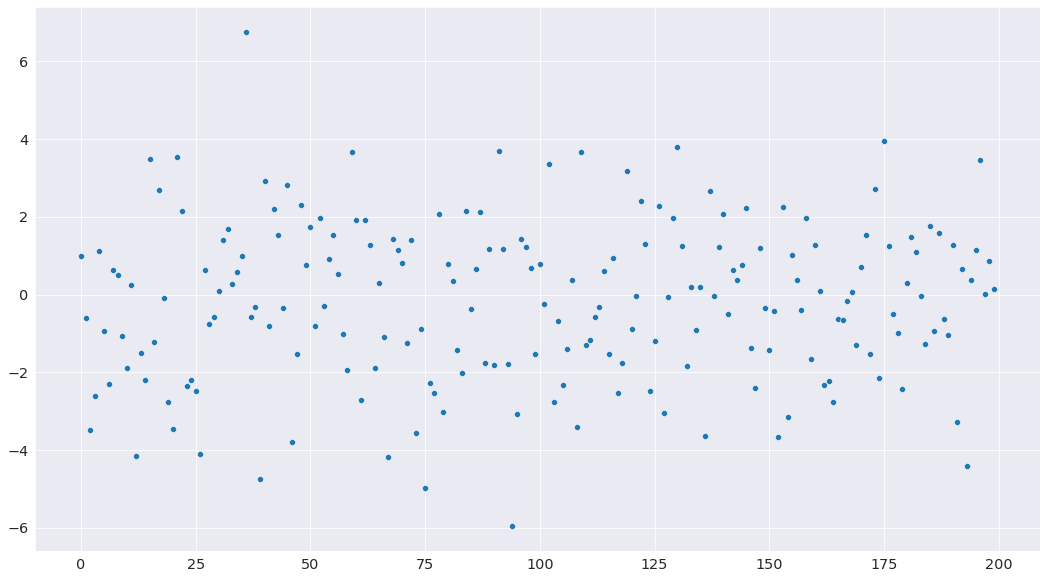

In [ ]:
data = np.random.normal(0, 2, (200))
plt.figure(figsize=(18, 10))
sns.scatterplot(x=np.arange(200), y=data)
plt.show()

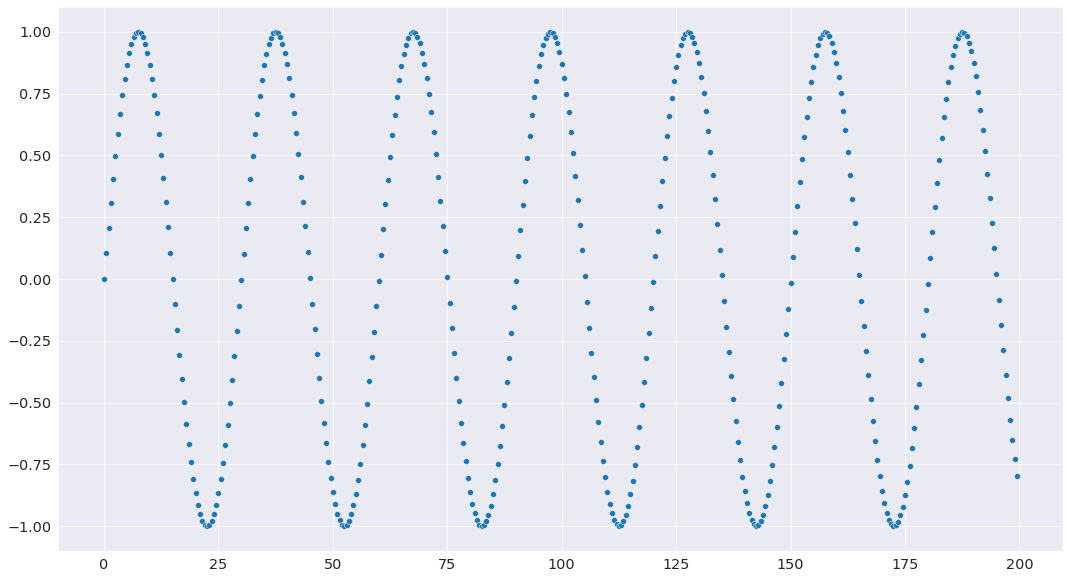

In [ ]:
x = np.arange(400)/2
y = np.sin(x * 6.28 / 30)
plt.figure(figsize=(18, 10))
sns.scatterplot(x=x, y=y)
plt.show()

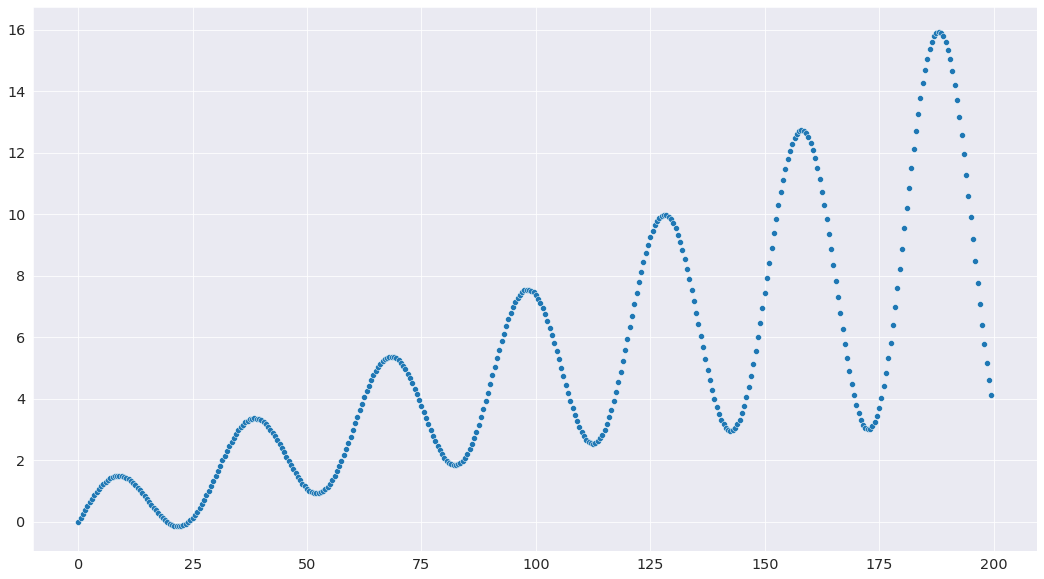

In [ ]:

x = np.arange(400)/2
y = np.sin(x * 6.28 / 30)*np.exp(x/100) + x/20
plt.figure(figsize=(18, 10))
sns.scatterplot(x=x, y=y)
plt.show()